# Chapter 4:  Classification with R - Logistic Regression 

In this chapter, 3 methods of classification were presented: Logistic Regression, Generative Models and Generalized Linear Models. Under these 3 methods, we have the specific methods as listed below:

- Generative Models: Linear Discriminant Analysis, Quadratic Discriminant Analysis, Naive Bayes

- Generalized Linear Models: Poisson regression

In this notebook, we will focus only on the first method: Logistic regression and its variants. 

# Dataset: 'Smarket'

In [1]:
library(ISLR2)

In [2]:
attach(Smarket)

This data set consists of percentage returns for the S&P 500 stock index over 1, 250 days, from the beginning of 2001 until the end of 2005. For each date, we have recorded the percentage returns for each of the five previous trading days, *Lag1* through *Lag5*. We have also recorded *Volume* (the number of shares traded on the previous day, in billions), *Today* (the percentage return on the date in question) and *Direction* (whether the market was Up or Down on this date). Our goal is to predict *Direction* (a qualitative response) using the other features.

In [3]:
names(Smarket)
print('The dimension of the dataset is:')
dim(Smarket)

[1] "Year"      "Lag1"      "Lag2"      "Lag3"      "Lag4"      "Lag5"     
[7] "Volume"    "Today"     "Direction"

[1] "The dimension of the dataset is:"


[1] 1250    9

In [4]:
head(Smarket)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up
6,2001,0.213,0.614,-0.623,1.032,0.959,1.3491,1.392,Up


In [5]:
summary(Smarket)

      Year           Lag1                Lag2                Lag3          
 Min.   :2001   Min.   :-4.922000   Min.   :-4.922000   Min.   :-4.922000  
 1st Qu.:2002   1st Qu.:-0.639500   1st Qu.:-0.639500   1st Qu.:-0.640000  
 Median :2003   Median : 0.039000   Median : 0.039000   Median : 0.038500  
 Mean   :2003   Mean   : 0.003834   Mean   : 0.003919   Mean   : 0.001716  
 3rd Qu.:2004   3rd Qu.: 0.596750   3rd Qu.: 0.596750   3rd Qu.: 0.596750  
 Max.   :2005   Max.   : 5.733000   Max.   : 5.733000   Max.   : 5.733000  
      Lag4                Lag5              Volume           Today          
 Min.   :-4.922000   Min.   :-4.92200   Min.   :0.3561   Min.   :-4.922000  
 1st Qu.:-0.640000   1st Qu.:-0.64000   1st Qu.:1.2574   1st Qu.:-0.639500  
 Median : 0.038500   Median : 0.03850   Median :1.4229   Median : 0.038500  
 Mean   : 0.001636   Mean   : 0.00561   Mean   :1.4783   Mean   : 0.003138  
 3rd Qu.: 0.596750   3rd Qu.: 0.59700   3rd Qu.:1.6417   3rd Qu.: 0.596750  
 Max. 

In [6]:
#calculate the correlations of the variables in the dataset, minus the 9th one
#which is qualitative (not numeric)
cor(Smarket[,-9])

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.00000000,0.029699649,0.030596422,0.033194581,0.035688718,0.029787995,0.53900647,0.030095229
Lag1,0.02969965,1.000000000,-0.026294328,-0.010803402,-0.002985911,-0.005674606,0.04090991,-0.026155045
Lag2,0.03059642,-0.026294328,1.000000000,-0.025896670,-0.010853533,-0.003557949,-0.04338321,-0.010250033
Lag3,0.03319458,-0.010803402,-0.025896670,1.000000000,-0.024051036,-0.018808338,-0.04182369,-0.002447647
Lag4,0.03568872,-0.002985911,-0.010853533,-0.024051036,1.000000000,-0.027083641,-0.04841425,-0.006899527
Lag5,0.02978799,-0.005674606,-0.003557949,-0.018808338,-0.027083641,1.000000000,-0.02200231,-0.034860083
Volume,0.53900647,0.040909908,-0.043383215,-0.041823686,-0.048414246,-0.022002315,1.00000000,0.014591823
Today,0.03009523,-0.026155045,-0.010250033,-0.002447647,-0.006899527,-0.034860083,0.01459182,1.000000000


The only substantial correlation is between Year and Volume. By plotting the data, which is ordered chronologically, we see that Volume is increasing over time. In other words, the average number of shares traded daily increased from 2001 to 2005.

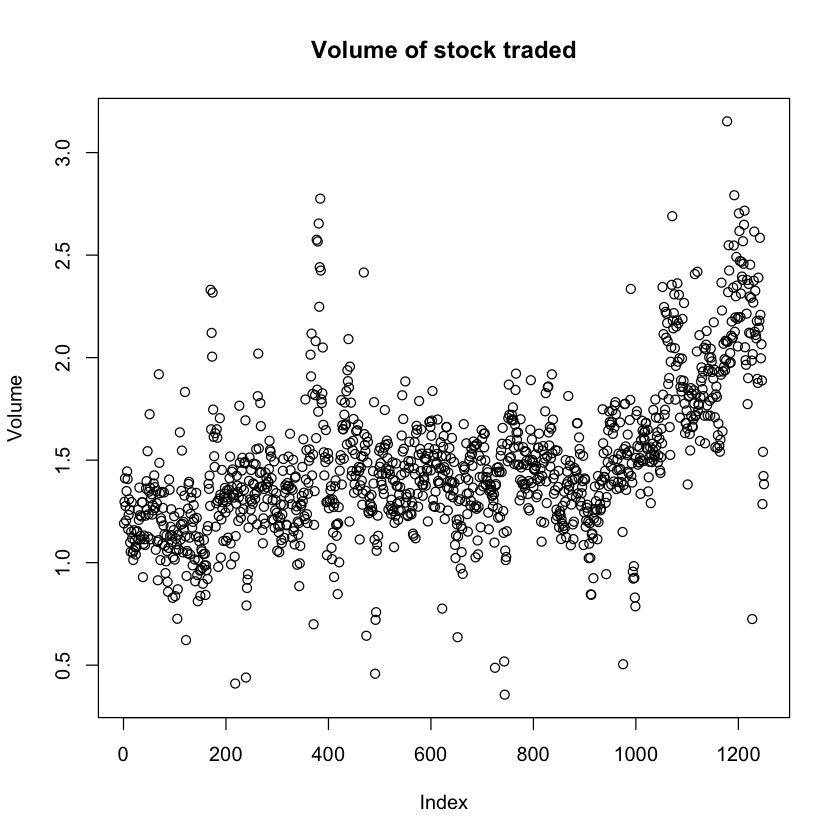

In [7]:
plot(Volume, main = 'Volume of stock traded')

Next, we will fit a logistic regression model in order to predict *Direction* using *Lag1* through *Lag5* and *Volume*. The *glm()* function can be used to fit many types of generalized linear models, including logistic regression. The syntax of the *glm()* function is similar to that of *lm()*, except that we must pass in the argument *family = binomial* in order to tell R to run a logistic regression rather than some other type of generalized linear model.

However, before doing that, we will quickly review the mathematical concepts behind logistic regression. 

# 4.1.1. Single logistic regression

Logistic regression models the probability of $X$ being either 0 or 1 by:

- $p(X) = \dfrac{e^{\beta_0 + \beta_1 X}}{1 + e^{\beta_0 + \beta_1 X}}$

A bit of manipulation leads to

- $log\left(\dfrac{p(X)}{(1-p(X)} \right) = \beta_0 + \beta_1 X$

The left hand side is called the logit. Increasing $X$ by 1 unit increases the logit by $\beta_1$, similar to the case in linear regression in which a 1-unit increase in $X$ increases $Y$ by $\beta_1$. 

To fit the model above, we use a method called maximum likelihood in which the parameters $\beta_0, \beta_1$ are those that maximize the likelihood function.

# 4.1.2 Multiple logistic regression

This case is the generalization of the single logistic regression case to multiple predictors $X_i$'s:

- $p(X) = \dfrac{e^{\beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p}}{1 + e^{\beta_0 + \beta_1 X_1+ \ldots + \beta_p X_p}}$

- $log\left(\dfrac{p(X)}{(1-p(X)} \right) = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p$

## Smarket dataset: No train-test split

In [14]:
glm.fits <- glm(Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume,
               family = binomial)
summary(glm.fits)


Call:
glm(formula = Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + 
    Volume, family = binomial)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.126000   0.240736  -0.523    0.601
Lag1        -0.073074   0.050167  -1.457    0.145
Lag2        -0.042301   0.050086  -0.845    0.398
Lag3         0.011085   0.049939   0.222    0.824
Lag4         0.009359   0.049974   0.187    0.851
Lag5         0.010313   0.049511   0.208    0.835
Volume       0.135441   0.158360   0.855    0.392

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1731.2  on 1249  degrees of freedom
Residual deviance: 1727.6  on 1243  degrees of freedom
AIC: 1741.6

Number of Fisher Scoring iterations: 3


The smallest p-value here is associated with *Lag1*. The negative coefficient for this predictor suggests that if the market had a positive return yesterday, then it is less likely to go up today. However, at a value of 0.15, the p-value is still relatively large, and so there is no clear evidence of a real association between *Lag1* and *Direction*.

In [15]:
coef(glm.fits)

(Intercept)         Lag1         Lag2         Lag3         Lag4         Lag5 
-0.126000257 -0.073073746 -0.042301344  0.011085108  0.009358938  0.010313068 
      Volume 
 0.135440659

The *predict()* function can be used to predict the probability that the market will go up, given values of the predictors. The *type = "response"* option tells R to output probabilities of the form $P(Y = 1|X)$, as opposed to other information such as the logit. 

In [16]:
glm.probs <- predict(glm.fits, type = "response")
glm.probs[1:10]

1         2         3         4         5         6         7         8 
0.5070841 0.4814679 0.4811388 0.5152224 0.5107812 0.5069565 0.4926509 0.5092292 
        9        10 
0.5176135 0.4888378

In order to make a prediction as to whether the market will go up or down on a particular day, we must convert these predicted probabilities into class labels, Up or Down. The following two commands create a vector of class predictions based on whether the predicted probability of a market increase is greater than or less than 0.5.

In [17]:
glm_pred <- rep('Down', 1250)
glm_pred[glm.probs > .5] = 'Up'

The first command creates a vector of 1,250 Down elements. The second line transforms to Up all of the elements for which the predicted probability of a market increase exceeds 0.5. Given these predictions, the *table()* function can be used to produce a confusion matrix in order to determine how many observations were correctly or incorrectly classified.


In [18]:
table(glm_pred, Direction)

        Direction
glm_pred Down  Up
    Down  145 141
    Up    457 507

In [20]:
#The accuracy is given by
mean(glm_pred == Direction)

[1] 0.5216

Although we got 52% accuracy, the result is not reliable because both training and testing were done on the same dataset. 

## Smarket dataset: Train-test split

We will first create a vector corresponding to the observations from 2001 through 2004. We will then use this vector to create a held out data set of observations from 2005.



In [21]:
train <- (Year < 2005)
Smarket_2005 <- Smarket[!train, ]
Direction_2005 <- Direction[!train]

In [27]:
dim(Smarket_2005)[1]
dim(Smarket_2005)

[1] 252

[1] 252   9

The object train is a Boolean vector, since its elements are TRUE and FALSE.

Therefore, *Smarket[!train, ]* yields a submatrix of the stock market data containing only the observations for which train is FALSE — that is, the observations with dates in 2005.

We now fit a logistic regression model using only the subset of the observations that correspond to dates before 2005, using the subset argument.

In [22]:
glm.fits <- glm(
Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume, 
    family = binomial, subset = train)

In [23]:
#Predicting the data for 2005
glm_probs <- predict(glm.fits, Smarket_2005,
type = "response")

In [28]:
#Create the confusion matrix
#first create a vector 252 'Down' then convert those > .5 to Up
glm_pred <- rep('Down', dim(Smarket_2005)[1])
glm_pred[glm_probs > .5] = 'Up'
#Now create the confusion matrix
table(glm_pred, Direction_2005)

        Direction_2005
glm_pred Down Up
    Down   77 97
    Up     34 44

In [29]:
mean(glm_pred == Direction_2005)

[1] 0.4801587

We only get 48% accuracy. 

## A model with fewer predictors

Perhaps by removing the variables that appear not to be helpful in predicting *Direction*, we can obtain a more effective model. After all, using predictors that have no relationship with the response tends to cause a deterioration in the test error rate (since such predictors cause an increase in variance without a corresponding decrease in bias), and so removing such predictors may in turn yield an improvement. Below we have refit the logistic regression using just *Lag1* and *Lag2*, which seemed to have the highest predictive power in the original logistic regression model.

In [30]:
glm_fits <- glm(Direction ~ Lag1 + Lag2, family = binomial, subset = train)
glm_probs <- predict(glm_fits, Smarket_2005, type = 'response')
glm_pred <- rep('Down', dim(Smarket_2005)[1])
glm_pred[glm_probs > .5] = 'Up'
table(glm_pred, Direction_2005)
mean(glm_pred == Direction_2005)

        Direction_2005
glm_pred Down  Up
    Down   35  35
    Up     76 106

[1] 0.5595238

In [31]:
#accuracy rate when the prediction is 'Up'
106/(106+76)

[1] 0.5824176

We get a better model with 55% accuracy. However, the confusion matrix shows that on days when logistic regression predicts an increase in the market, it has a 58% accuracy rate. This suggests a possible trading strategy of buying on days when the model predicts an increasing market, and avoiding trades on days when a decrease is predicted.

# 4.1.3. Multinomial logistic regression

Logistic regression only allows for classication of 2 categories: 0 or 1. Multinomial logistic regression allows for the classification of more than 2 categories. Suppose that there are $K$ classes labeled by the variable $k$:

$k = 1, \ldots, K$

then if we select the $K^{th}$ class to serve as the baseline, we have the following probabilities:

- $P(Y = K|X = x) = \dfrac{1}{1 + \sum_{l=K}^{K-1} \exp(\beta_{l0} + \beta_{l1}x_1 + \ldots + \beta_{lp}x_p)}$

- $P(Y = k|X = x) = \dfrac{\exp(\beta_{k0} + \beta_{k1}x_1 + \ldots + \beta_{kp}x_p)}{1 + \sum_{l=K}^{K-1} \exp(\beta_{l0} + \beta_{l1}x_1 + \ldots + \beta_{lp}x_p)},\,\,\,\,\,\,(k = 1, \ldots, K-1)$

For $k = 1, \ldots, K-1$, 

- $\log\left(\dfrac{P(Y = k|X = x)}{P(Y = K|X = x)}\right) =\beta_{k0} + \beta_{k1}x_1 + \ldots + \beta_{kp}x_p$.


The last equation above means that the log odds between any pair of classes is linear in the features.

It turns out that the decision to treat the $K^{th}$ class as the baseline is unimportant. For example, when classifying emergency room visits into *stroke, drug overdose*, and *epileptic seizure*, suppose that we fit two multinomial logistic regression models: one treating *stroke* as the baseline, another treating *drug overdose* as the baseline. The coefficient estimates will differ between the two fitted models due to the differing choice of baseline, but the fitted values (predictions), the log odds between any pair of classes, and the other key model outputs will remain the same. Nonetheless, interpretation of the coefficients in a multinomial logistic regression model must be done with care, since it is tied to the choice of baseline. A 1-unit increase in $X_j$ is associated with a $\beta_{kj}$ increase in the log odds of class $k$ over the baseline class. 